In [1]:
import sys
import geopandas as gpd
import multiprocessing

sys.path.append('../utils')
import data_paths
from traffic_counts import TrafficCounts
from hbefa_hot_emissions import HbefaHotEmissions
from excel_calendar import Calendar
from gridding import GriddingEngine

import inventory_processing

# Import data and initialize objects

In [2]:
# import visum model
visum = gpd.read_file(data_paths.VISUM_FOLDER_PATH + 'visum_links.gpkg')
# initialize calendar
cal = Calendar()
# initialize traffic cycles
cycles = TrafficCounts()
# initialize HBEFA emission factors
hbefa = HbefaHotEmissions()

# since there are no scaling factors for every road type but aggregated time profiles, 
# a column 'scaling_road_type' is introduced to match the scaling factors with the visum model
scaling_road_types = {'Motorway-Nat': 'Motorway-Nat',
                        'Motorway-City': 'Motorway-Nat',
                        'TrunkRoad/Primary-National': 'Distributor/Secondary', 
                        'TrunkRoad/Primary-City': 'TrunkRoad/Primary-City',
                        'Distributor/Secondary': 'Distributor/Secondary',
                        'Local/Collector': 'Distributor/Secondary',
                        'Access-residential': 'Distributor/Secondary'}
            
visum['scaling_road_type'] = visum['road_type'].map(scaling_road_types)

Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_PC.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_LCV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_HGV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_Coach.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_MOT.XLS


In [3]:
# get dates for normweekdays in 2019
dates = cal.get_calendar()
dates['combined_day_type'] = dates['date'].apply(cal.get_day_type_combined)
normweekdays_2019 = dates [(dates['date'].between('2019-01-01','2019-12-31')) &
                           (dates['combined_day_type'] == 0)]['date']

# calculate vehicle shares on average norm weekday in 2019
# these values are used to calculate the vehicle share correction factors
weekday_shares_2019 = cycles.vehicle_shares.loc[:,normweekdays_2019].reset_index()
weekday_shares_2019 = weekday_shares_2019.groupby(['road_type','vehicle_class'])[0].mean()

visum['hgv_corr'] = visum.apply(lambda row : row['delta_HGV'] / weekday_shares_2019.loc[row['scaling_road_type'],'HGV'], axis = 1)
visum['lcv_corr'] = visum.apply(lambda row : row['delta_LCV'] / weekday_shares_2019.loc[row['scaling_road_type'],'LCV'], axis = 1)

In [4]:
#NUMBER_OF_PROCESSES = multiprocessing.cpu_count()
NUMBER_OF_PROCESSES = 6
df = cal.get_calendar()
dates = [d.strftime("%Y-%m-%d") for d in df[df['date'].between('2019-01-01','2019-01-06')]['date']]

visum = visum.reset_index(drop = True).reset_index()

parameters = [(d,visum.to_dict('records'), cycles, hbefa, False) for d in dates]

with multiprocessing.Pool(NUMBER_OF_PROCESSES) as pool:
    res = pool.starmap(inventory_processing.calculate_daily_co2_emissions, parameters)

Finished 2019-01-01
Finished 2019-01-02
Finished 2019-01-03
Finished 2019-01-04
Finished 2019-01-05
Finished 2019-01-06


In [6]:
emission_dict = {index:0 for index in visum['index'].unique()}

for item in res: 
    if item == 0:
        continue
    else:
        # we have data to process
        for key, value in item.items():
            sum_emission = sum([k for k in value.values() if k == k])
            emission_dict[key] += sum_emission

In [7]:
visum['emissions'] = visum['index'].map(emission_dict)

visum_plot = visum.groupby('road_link_id').agg({'emissions': 'sum', 'geometry': (lambda x: x.iloc[0])})

visum_plot = gpd.GeoDataFrame(visum_plot,  geometry=visum_plot['geometry'], crs = 25832)

/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_62221/1325238765.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  visum_plot.plot(ax=ax, column = 'emissions', cmap = matplotlib.cm.get_cmap('twilight_shifted'), norm=matplotlib.colors.LogNorm())


<Axes: >

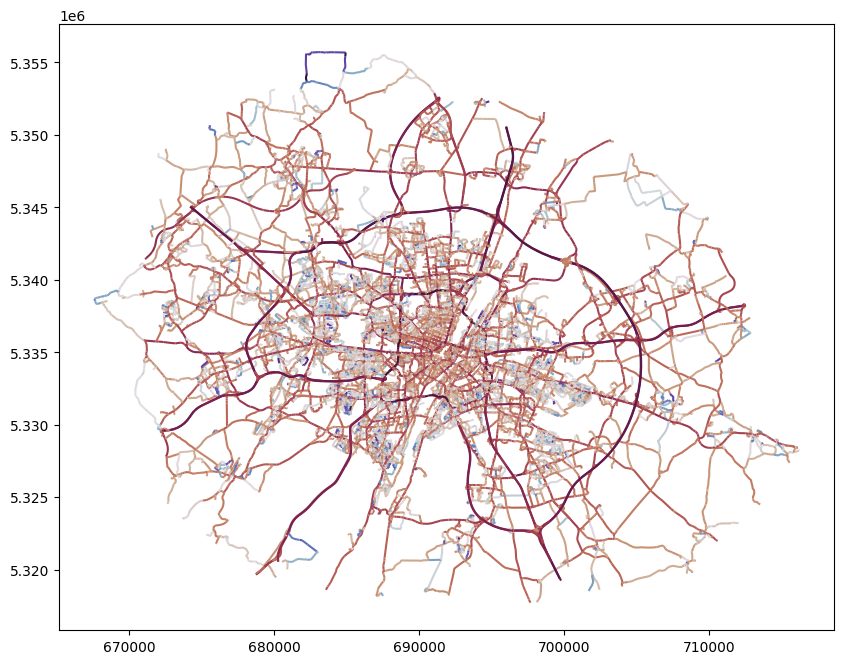

In [8]:
import matplotlib
import matplotlib.pyplot as plt

fig, ax  = plt.subplots(figsize = (10,10), frameon=False)
visum_plot.plot(ax=ax, column = 'emissions', cmap = matplotlib.cm.get_cmap('twilight_shifted'), norm=matplotlib.colors.LogNorm())

In [9]:
visum_plot.head()

,emissions,geometry
road_link_id,,
3,1.808742e+06,"LINESTRING (693813.955 5333851.376, 693782.675..."
4,3.781228e+06,"LINESTRING (694656.800 5329709.405, 694732.757..."
7,9.196301e+05,"LINESTRING (694893.323 5343117.529, 694887.098..."
10,3.970416e+06,"LINESTRING (692049.103 5333731.253, 692027.091..."
12,8.363135e+05,"LINESTRING (686959.296 5337141.890, 686990.212..."


In [13]:
in_grid = gpd.read_file(data_paths.TNO_100M_GRID)
grd = GriddingEngine(input_grid=in_grid, crs =25832)
out_grd = grd.overlay_grid(geom_input=visum_plot, value_columns='emissions', source_type='line')

/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_62221/1621897011.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  out_grd.plot(ax=ax, column = 'emissions', cmap = matplotlib.cm.get_cmap('twilight_shifted'), norm=matplotlib.colors.LogNorm())


<Axes: >

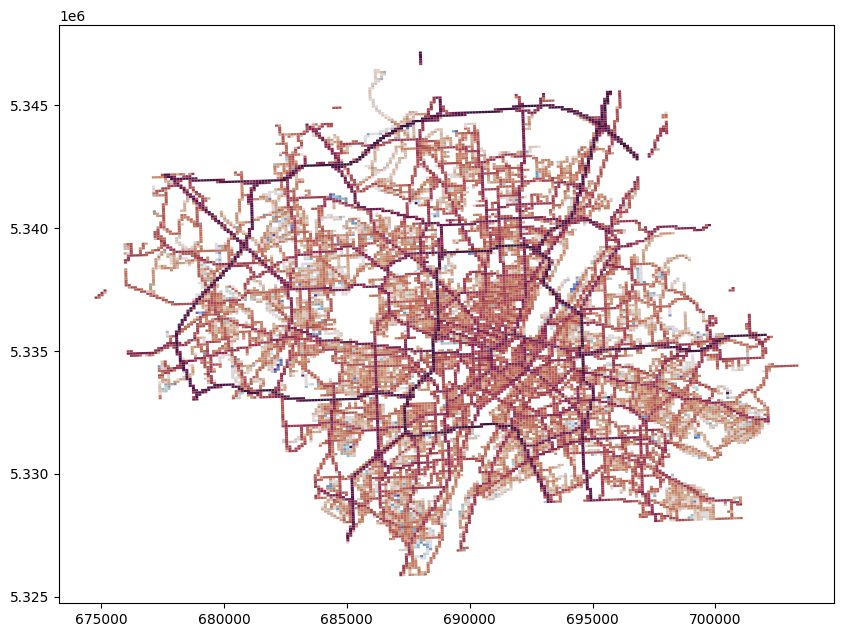

In [14]:
fig, ax  = plt.subplots(figsize = (10,10), frameon=False)
out_grd.plot(ax=ax, column = 'emissions', cmap = matplotlib.cm.get_cmap('twilight_shifted'), norm=matplotlib.colors.LogNorm())